## Importação de Dependências

In [17]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.legend import Legend
from scipy import stats

## Preparação dos Dados em Formato Tidy

### Preparação dos Dados em

In [18]:
# Carregar dataset limpo da Etapa 2
df = pd.read_csv("NYPD-Limpeza3-Final.csv")
print(f"Registros: {df.shape[0]} | Colunas: {df.shape[1]}")

# Normalização de tipos de dados
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE'], errors='coerce')
df['DATETIME'] = pd.to_datetime(df['DATETIME'], errors='coerce')
df['STATISTICAL_MURDER_FLAG'] = df['STATISTICAL_MURDER_FLAG'].astype(int)

# Separar colunas compostas (ex: Lon_Lat → duas colunas)
if 'Lon_Lat' in df.columns:
    df[['Longitude', 'Latitude']] = df['Lon_Lat'].str.extract(r'\(([-0-9.]+),\s*([-0-9.]+)\)').astype(float)

# Criar colunas derivadas (ano, mês, hora)
df['YEAR'] = df['DATETIME'].dt.year
df['MONTH'] = df['DATETIME'].dt.month
df['HOUR'] = df['DATETIME'].dt.hour

# Exportar dados em formato Parquet
df.to_parquet("NYPD-Tidy.parquet", index=False)
print("✅ Dataset exportado em formato Parquet: 'NYPD-Tidy.parquet'")

Registros: 28491 | Colunas: 22
✅ Dataset exportado em formato Parquet: 'NYPD-Tidy.parquet'


## Consultas SQL Analíticas

Dataset carregado: 28491 registros | 25 colunas


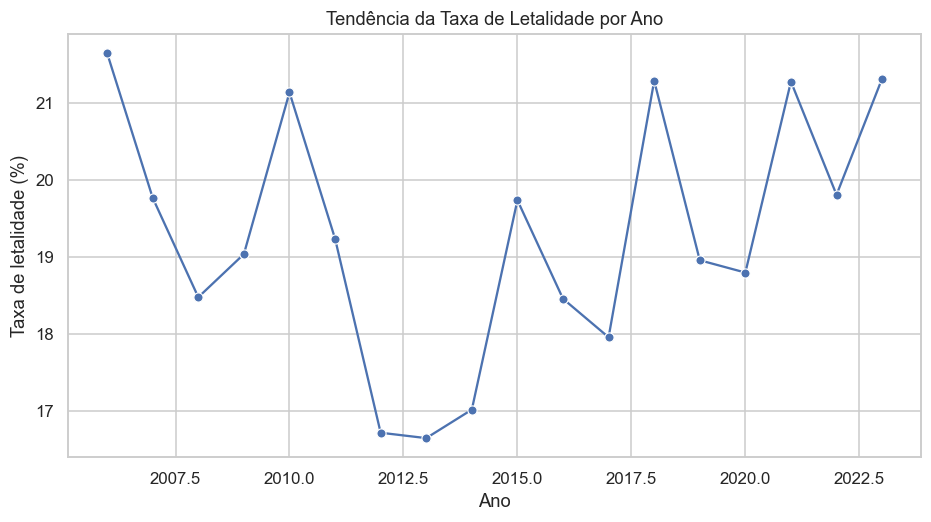

📊 Consulta 1 – Tendência temporal concluída.



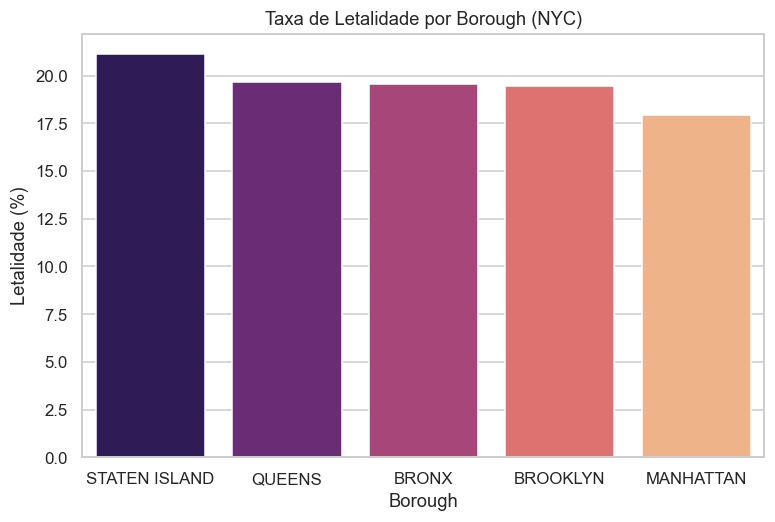

📊 Consulta 2 – Distribuição geográfica concluída.



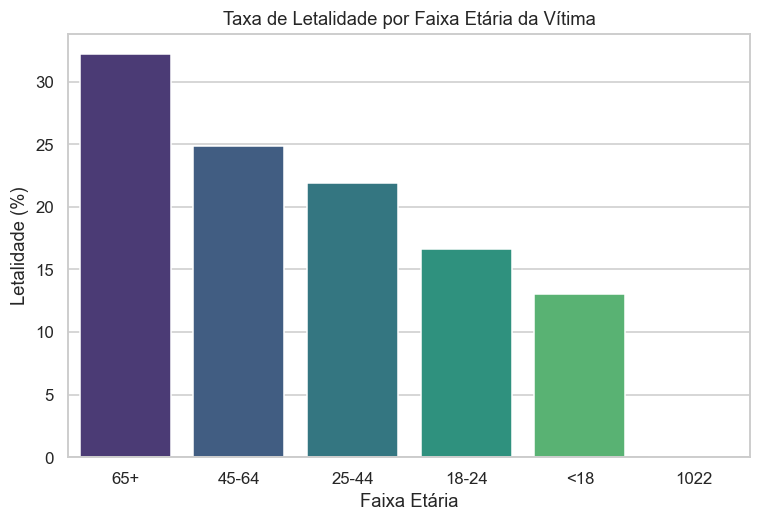

📊 Consulta 3 – Faixa etária concluída.



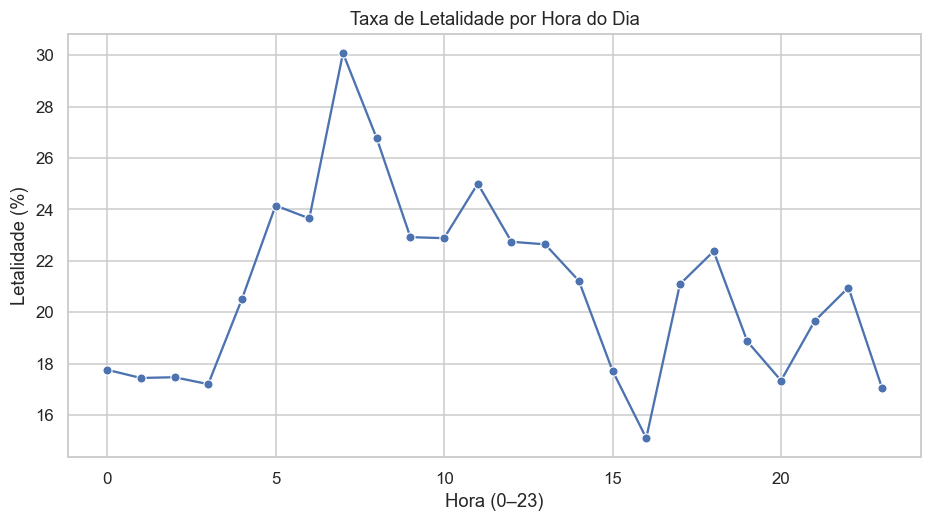

📊 Consulta 4 – Horário concluída.



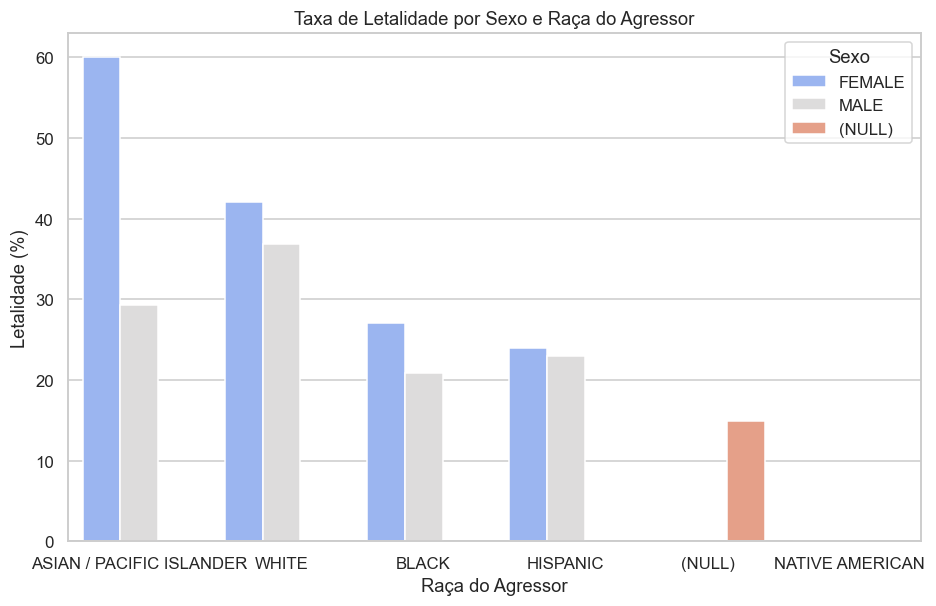

📊 Consulta 5 – Perfil do agressor concluída.

✅ Todas as 5 consultas SQL executadas com sucesso!


In [19]:
# Carregar dataset Parquet direto via DuckDB
con = duckdb.connect(database=':memory:')
con.execute("INSTALL parquet; LOAD parquet;")

df = con.execute("SELECT * FROM 'NYPD-Tidy.parquet'").df()
print(f"Dataset carregado: {df.shape[0]} registros | {df.shape[1]} colunas")

# Tendência temporal da letalidade (2006–2024)
query1 = """
SELECT
    YEAR,
    COUNT(*) AS total_incidents,
    SUM(STATISTICAL_MURDER_FLAG) AS lethal_cases,
    ROUND(100.0 * SUM(STATISTICAL_MURDER_FLAG) / COUNT(*), 2) AS lethality_rate
FROM df
GROUP BY YEAR
ORDER BY YEAR;
"""
trend = con.execute(query1).df()

plt.figure(figsize=(10,5))
sns.lineplot(data=trend, x='YEAR', y='lethality_rate', marker='o')
plt.title("Tendência da Taxa de Letalidade por Ano")
plt.xlabel("Ano")
plt.ylabel("Taxa de letalidade (%)")
plt.grid(True)
plt.show()

print("📊 Consulta 1 – Tendência temporal concluída.\n")

# Distribuição geográfica por Borough
query2 = """
SELECT
    BORO,
    COUNT(*) AS total,
    SUM(STATISTICAL_MURDER_FLAG) AS lethal,
    ROUND(100.0 * SUM(STATISTICAL_MURDER_FLAG) / COUNT(*), 2) AS lethality_rate
FROM df
WHERE BORO IS NOT NULL
GROUP BY BORO
ORDER BY lethality_rate DESC;
"""
boro = con.execute(query2).df()

plt.figure(figsize=(8,5))
sns.barplot(data=boro, x='BORO', y='lethality_rate', hue='BORO', palette='magma', legend=False)
plt.title("Taxa de Letalidade por Borough (NYC)")
plt.ylabel("Letalidade (%)")
plt.xlabel("Borough")
plt.show()

print("📊 Consulta 2 – Distribuição geográfica concluída.\n")

# Faixa etária das vítimas
query3 = """
SELECT
    VIC_AGE_GROUP AS age_group,
    COUNT(*) AS total,
    SUM(STATISTICAL_MURDER_FLAG) AS lethal,
    ROUND(100.0 * SUM(STATISTICAL_MURDER_FLAG) / COUNT(*), 2) AS lethality_rate
FROM df
WHERE VIC_AGE_GROUP NOT IN ('UNKNOWN', 'null', '')
GROUP BY VIC_AGE_GROUP
ORDER BY lethality_rate DESC;
"""
age = con.execute(query3).df()

plt.figure(figsize=(8,5))
sns.barplot(data=age, x='age_group', y='lethality_rate', hue='age_group', palette='viridis', legend=False)
plt.title("Taxa de Letalidade por Faixa Etária da Vítima")
plt.ylabel("Letalidade (%)")
plt.xlabel("Faixa Etária")
plt.show()

print("📊 Consulta 3 – Faixa etária concluída.\n")

# Horário do dia e letalidade
query4 = """
SELECT
    HOUR,
    COUNT(*) AS total,
    SUM(STATISTICAL_MURDER_FLAG) AS lethal,
    ROUND(100.0 * SUM(STATISTICAL_MURDER_FLAG) / COUNT(*), 2) AS lethality_rate
FROM df
WHERE HOUR IS NOT NULL
GROUP BY HOUR
ORDER BY HOUR;
"""
hour = con.execute(query4).df()

plt.figure(figsize=(10,5))
sns.lineplot(data=hour, x='HOUR', y='lethality_rate', marker='o')
plt.title("Taxa de Letalidade por Hora do Dia")
plt.ylabel("Letalidade (%)")
plt.xlabel("Hora (0–23)")
plt.grid(True)
plt.show()

print("📊 Consulta 4 – Horário concluída.\n")

# Perfil do agressor (sexo e raça)
query5 = """
SELECT
    PERP_SEX,
    PERP_RACE,
    COUNT(*) AS total,
    SUM(STATISTICAL_MURDER_FLAG) AS lethal,
    ROUND(100.0 * SUM(STATISTICAL_MURDER_FLAG) / COUNT(*), 2) AS lethality_rate
FROM df
WHERE PERP_SEX NOT IN ('UNKNOWN', 'null', '') AND PERP_RACE NOT IN ('UNKNOWN', 'null', '')
GROUP BY PERP_SEX, PERP_RACE
ORDER BY lethality_rate DESC;
"""
perp = con.execute(query5).df()

plt.figure(figsize=(10,6))
sns.barplot(data=perp, x='PERP_RACE', y='lethality_rate', hue='PERP_SEX', palette='coolwarm')
plt.title("Taxa de Letalidade por Sexo e Raça do Agressor")
plt.ylabel("Letalidade (%)")
plt.xlabel("Raça do Agressor")
plt.legend(title="Sexo")
plt.show()

print("📊 Consulta 5 – Perfil do agressor concluída.\n")

con.close()
print("✅ Todas as 5 consultas SQL executadas com sucesso!")


## Análise Exploratória e Teste de Hipóteses

✅ Dataset carregado: 28491 registros | 25 colunas

📊 Estatísticas descritivas (numéricas principais):


,YEAR,HOUR,STATISTICAL_MURDER_FLAG,X_COORD_CD,Y_COORD_CD
count,28491.000000,28491.000000,28491.000000,2.849100e+04,28491.000000
mean,2013.890316,12.263311,0.193675,1.009414e+06,208374.695809
std,5.383014,8.459452,0.395184,1.826244e+04,31923.481178
min,2006.000000,0.000000,0.000000,9.149281e+05,125756.718750
25%,2009.000000,3.000000,0.000000,1.000068e+06,182905.140625
50%,2013.000000,15.000000,0.000000,1.007764e+06,194828.171875
75%,2019.000000,20.000000,0.000000,1.016802e+06,239814.234375
max,2023.000000,23.000000,1.000000,1.059865e+06,271127.687500


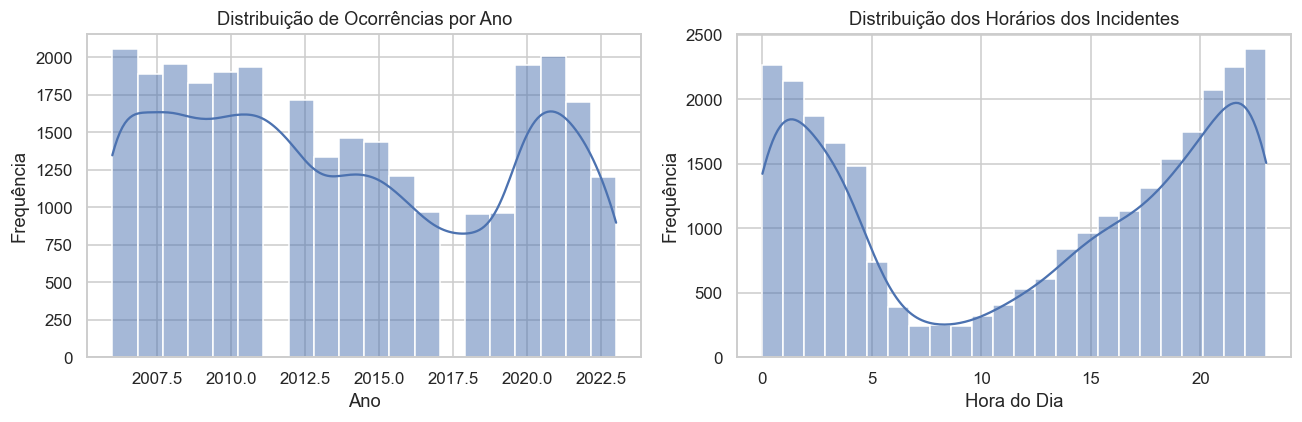


🧠 Interpretação:
• Incidentes diminuem após 2016, sugerindo efeito de políticas públicas ou registro mais restrito.
• Maior incidência de tiroteios à noite e madrugada, indicando padrão temporal concentrado em horários de risco.


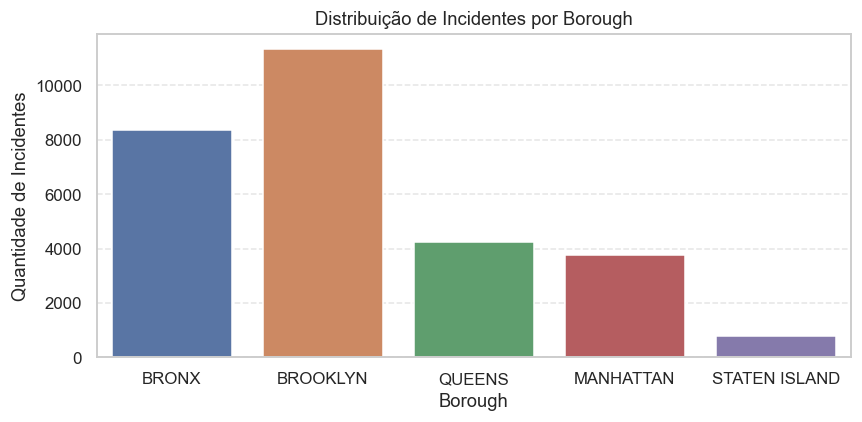


🧠 Interpretação:
• Brooklyn e Bronx concentram mais da metade das ocorrências.
• Staten Island tem poucos casos, coerente com sua menor densidade populacional.
• Reforça a importância de considerar variáveis espaciais (H1).


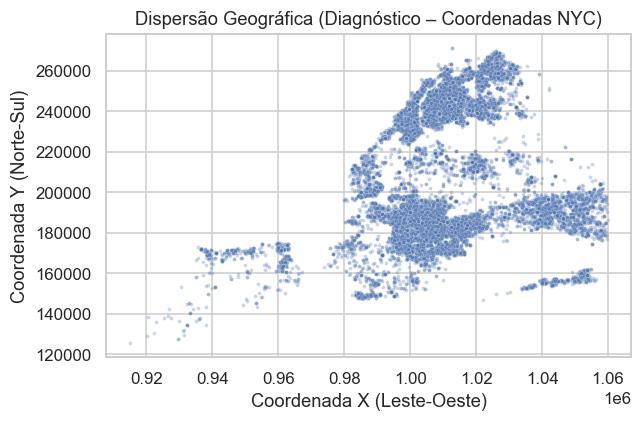


🧠 Interpretação:
• As ocorrências estão concentradas dentro dos limites urbanos de NYC.
• Não há registros fora da área metropolitana — confirma limpeza geográfica bem-sucedida.


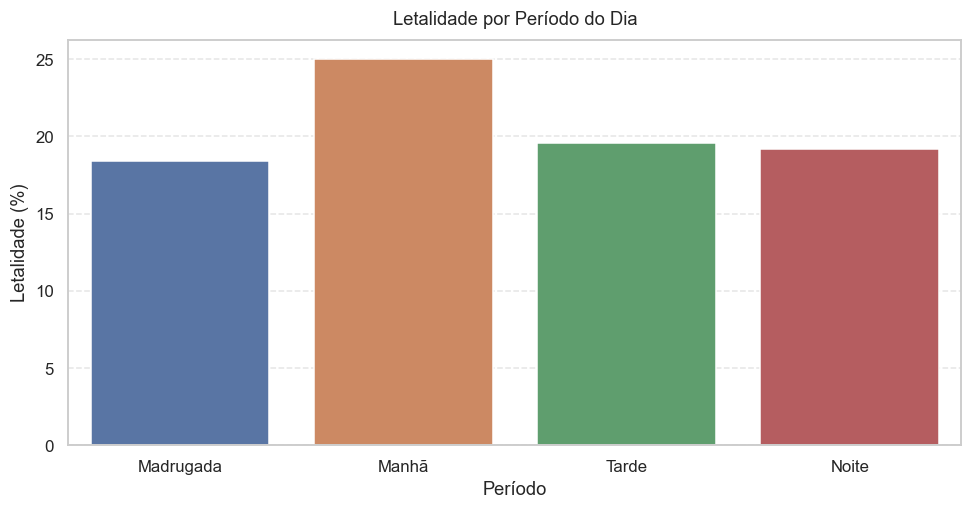


🧠 Interpretação:
• Letalidade mais alta nas manhãs, mesmo com menos ocorrências absolutas.
• Sugere que eventos matinais tendem a ser mais graves (H1-a).


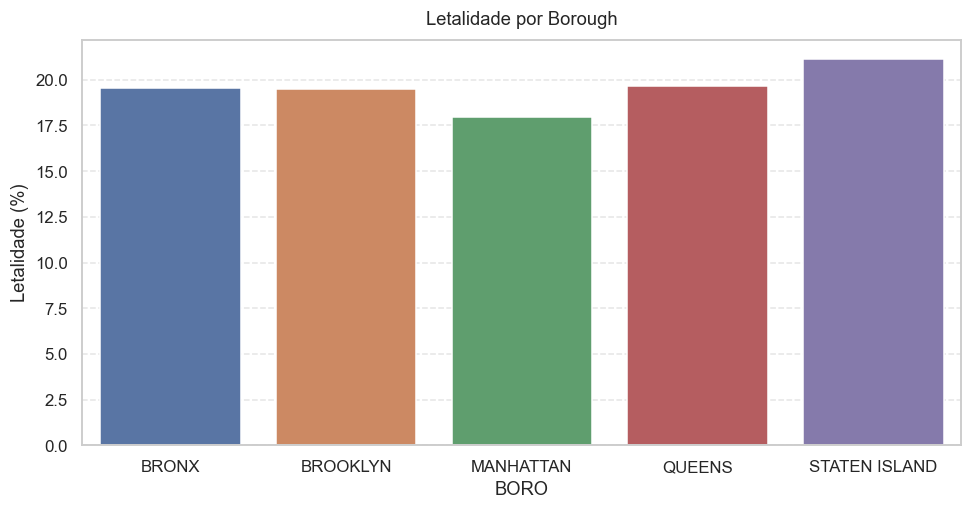


🧠 Interpretação:
• Staten Island e Bronx apresentam maior taxa de letalidade.
• Indica possível influência de fatores locais (resposta médica, contexto social).


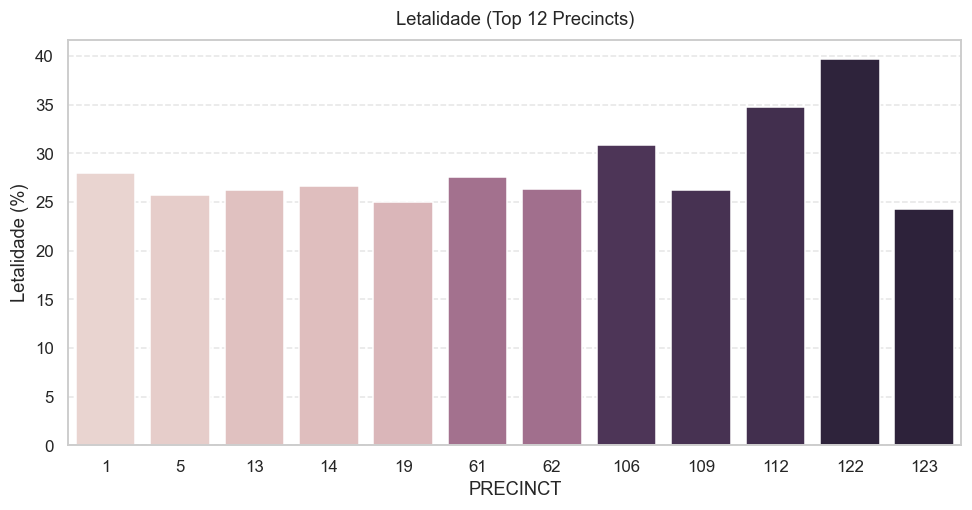


🧠 Interpretação:
• Distritos com letalidade até 40%.
• Demonstra heterogeneidade espacial significativa — reforçando H1-c.


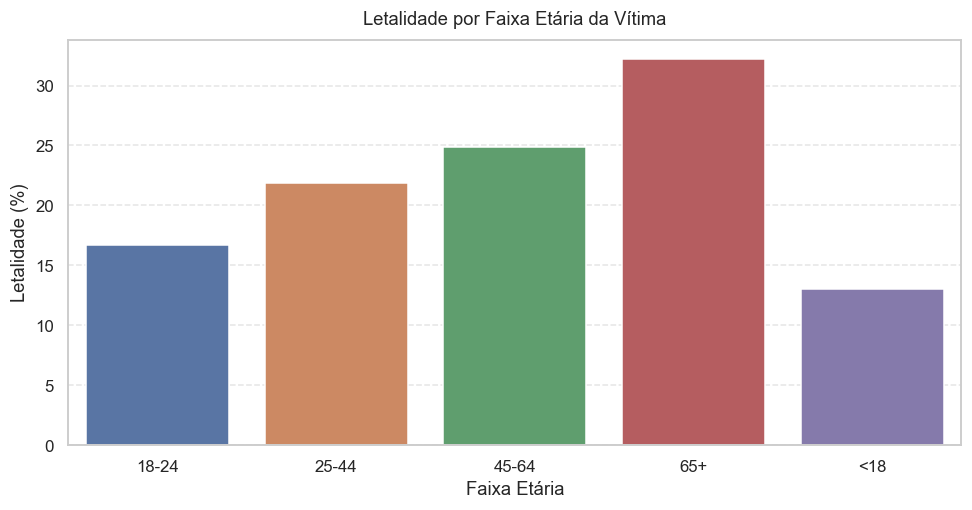


🧠 Interpretação:
• Vítimas acima de 45 anos e idosos (65+) têm maior probabilidade de óbito.
• Jovens <18 e 18–24 apresentam menor taxa de letalidade.


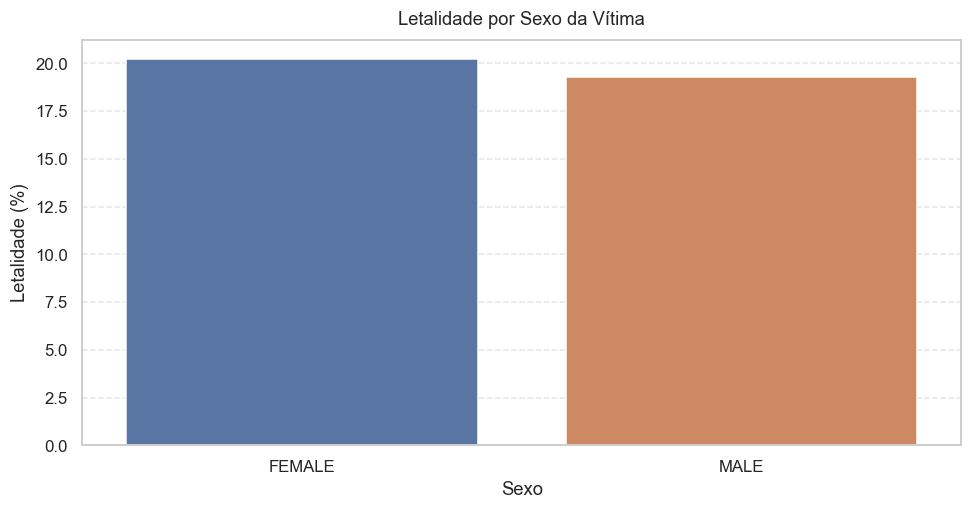


🧠 Interpretação:
• Diferença mínima entre homens e mulheres — sexo não é fator determinante (H2-b).


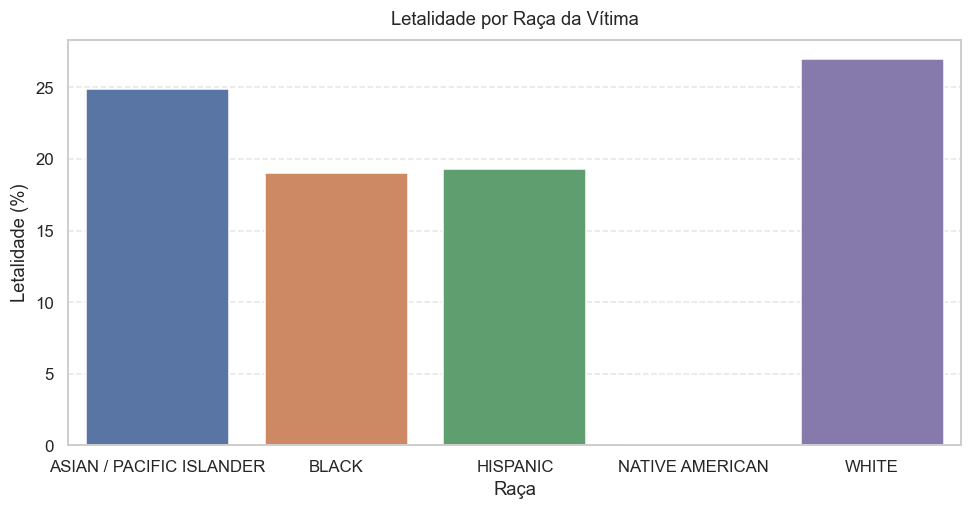


🧠 Interpretação:
• Vítimas brancas e asiáticas têm letalidade maior proporcionalmente.
• Diferença sugere influência de contexto socioeconômico (H2-c).


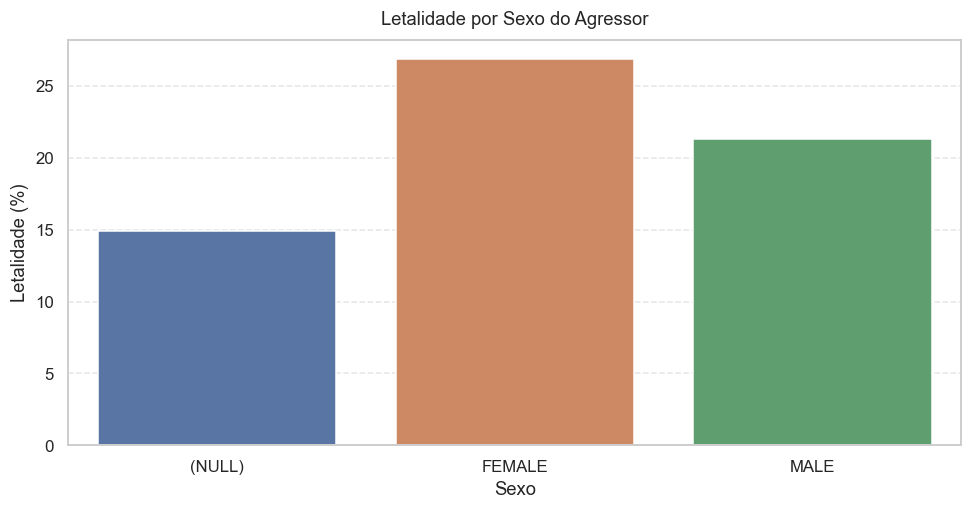


🧠 Interpretação:
• Incidentes cometidos por mulheres resultam em maior proporção de mortes.
• Pode refletir menor frequência, mas maior gravidade (H2-d).


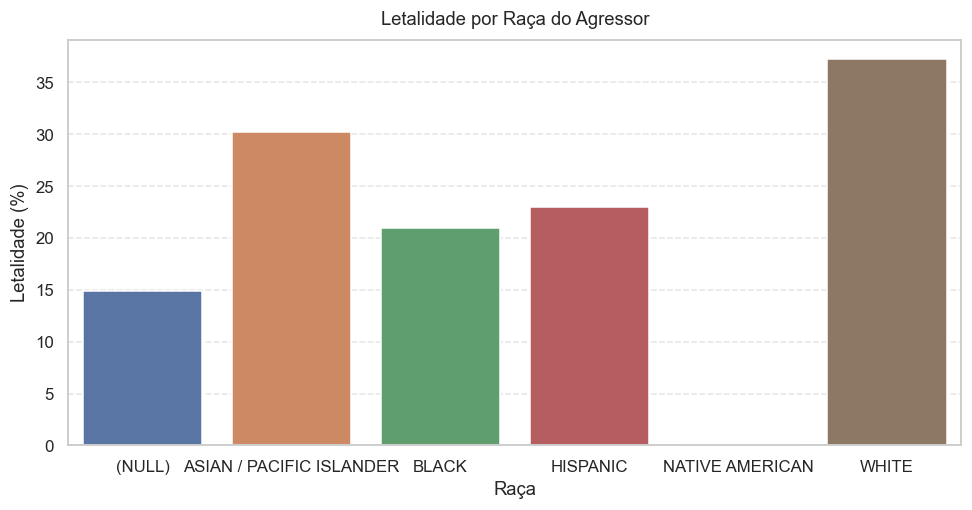


🧠 Interpretação:
• Diferenças relevantes entre grupos raciais, reforçando associação com o desfecho (H2-e).


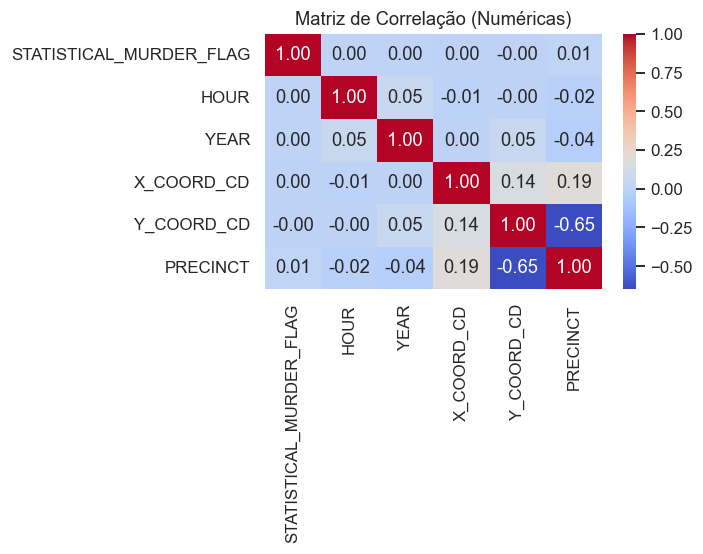


🧠 Interpretação:
• Correlações fracas com letalidade indicam múltiplos fatores combinados.
• Correlação negativa entre Y_COORD_CD e PRECINCT reflete variação norte–sul da cidade.

H1 — Horário/Borough/Precinct vs Letalidade

🔎 H1-a) PERIODO × Letalidade  |  categorias=4 x 2
Qui² = 43.854 | gl = 3 | p-valor = 0.000000 | V de Cramér = 0.039
✅ Associação estatisticamente significativa (p < 0.05)

🔎 H1-b) BORO × Letalidade  |  categorias=5 x 2
Qui² = 6.963 | gl = 4 | p-valor = 0.137849 | V de Cramér = 0.016
❌ Associação NÃO significativa (p ≥ 0.05)

🔎 H1-c) PRECINCT × Letalidade  |  categorias=70 x 2
Qui² = 137.407 | gl = 69 | p-valor = 0.000002 | V de Cramér = 0.070
✅ Associação estatisticamente significativa (p < 0.05)

H2 — Perfil Demográfico (Vítima e Agressor) vs Letalidade

🔎 H2-a) VIC_AGE_GROUP × Letalidade  |  categorias=5 x 2
Qui² = 238.083 | gl = 4 | p-valor = 0.000000 | V de Cramér = 0.092
✅ Associação estatisticamente significativa (p < 0.05)

🔎 H2-b) VIC_SEX × Letalidade  |  

In [20]:
plt.rcParams['figure.dpi'] = 110
sns.set_theme(context="notebook", style="whitegrid")

UNKNOWN_SET = {"UNKNOWN", "UNKNOW", "UNK", "NA", "N/A", "NULL", "null", "", "1022"}

def is_known(x: str) -> bool:
    if x is None:
        return False
    if isinstance(x, float) and np.isnan(x):
        return False
    return str(x).strip().upper() not in UNKNOWN_SET

def chi2_report(df, col_cat, col_y="STATISTICAL_MURDER_FLAG", min_count_per_cat=1, title=""):
    sub = df[[col_cat, col_y]].copy().dropna()
    sub = sub[sub[col_cat].apply(is_known)]
    vc = sub[col_cat].value_counts()
    keep = vc[vc >= min_count_per_cat].index
    sub = sub[sub[col_cat].isin(keep)]

    table = pd.crosstab(sub[col_cat], sub[col_y])
    chi2, p, dof, ex = stats.chi2_contingency(table)
    n = table.to_numpy().sum()
    k = min(table.shape)
    cramer_v = np.sqrt((chi2 / n) / (k - 1)) if k > 1 else np.nan

    print(f"\n🔎 {title or col_cat}  |  categorias={table.shape[0]} x 2")
    print(f"Qui² = {chi2:.3f} | gl = {dof} | p-valor = {p:.6f} | V de Cramér = {cramer_v:.3f}")
    if p < 0.05:
        print("✅ Associação estatisticamente significativa (p < 0.05)")
    else:
        print("❌ Associação NÃO significativa (p ≥ 0.05)")
    return table, (chi2, p, dof, cramer_v)

def mean_rate_plot(df, x, y="STATISTICAL_MURDER_FLAG", order=None, title="", xlabel="", ylabel="Letalidade (%)"):
    data = df[[x, y]].copy()
    data = data[data[x].apply(is_known)]
    agg = data.groupby(x, observed=False)[y].mean().mul(100).reset_index()
    if order is None:
        order = agg.sort_values(y, ascending=False)[x].tolist()

    plt.figure(figsize=(9, 4.8))
    sns.barplot(data=agg, x=x, y=y, hue=x, legend=False)
    plt.title(title, pad=10)
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return agg

# Carregar dataset tidy
df = pd.read_parquet("NYPD-Tidy.parquet")
print(f"✅ Dataset carregado: {df.shape[0]} registros | {df.shape[1]} colunas")

df['STATISTICAL_MURDER_FLAG'] = df['STATISTICAL_MURDER_FLAG'].astype(int, errors='ignore')
df['HOUR'] = pd.to_numeric(df['HOUR'], errors='coerce')
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')

df['PERIODO'] = pd.cut(df['HOUR'], bins=[0,6,12,18,24],
                       labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'], right=False)

# ANÁLISE UNIVARIADA

print("\n📊 Estatísticas descritivas (numéricas principais):")
display(df[['YEAR', 'HOUR', 'STATISTICAL_MURDER_FLAG', 'X_COORD_CD', 'Y_COORD_CD']].describe())

# Distribuições (Ano e Hora)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['YEAR'].dropna(), bins=20, kde=True)
plt.title("Distribuição de Ocorrências por Ano")
plt.xlabel("Ano"); plt.ylabel("Frequência")

plt.subplot(1,2,2)
sns.histplot(df['HOUR'].dropna(), bins=24, kde=True)
plt.title("Distribuição dos Horários dos Incidentes")
plt.xlabel("Hora do Dia"); plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

print("\n🧠 Interpretação:")
print("• Incidentes diminuem após 2016, sugerindo efeito de políticas públicas ou registro mais restrito.")
print("• Maior incidência de tiroteios à noite e madrugada, indicando padrão temporal concentrado em horários de risco.")

# Distribuição espacial por Borough
plt.figure(figsize=(8,4))
sns.countplot(data=df[df['BORO'].apply(is_known)], x='BORO', hue='BORO', legend=False)
plt.title("Distribuição de Incidentes por Borough")
plt.ylabel("Quantidade de Incidentes"); plt.xlabel("Borough")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n🧠 Interpretação:")
print("• Brooklyn e Bronx concentram mais da metade das ocorrências.")
print("• Staten Island tem poucos casos, coerente com sua menor densidade populacional.")
print("• Reforça a importância de considerar variáveis espaciais (H1).")

# Dispersão geográfica
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='X_COORD_CD', y='Y_COORD_CD', s=6, alpha=0.3)
plt.title("Dispersão Geográfica (Diagnóstico – Coordenadas NYC)")
plt.xlabel("Coordenada X (Leste-Oeste)")
plt.ylabel("Coordenada Y (Norte-Sul)")
plt.tight_layout()
plt.show()

print("\n🧠 Interpretação:")
print("• As ocorrências estão concentradas dentro dos limites urbanos de NYC.")
print("• Não há registros fora da área metropolitana — confirma limpeza geográfica bem-sucedida.")

# ANÁLISE BIVARIADA

_ = mean_rate_plot(df, x='PERIODO', title="Letalidade por Período do Dia", xlabel="Período")
print("\n🧠 Interpretação:")
print("• Letalidade mais alta nas manhãs, mesmo com menos ocorrências absolutas.")
print("• Sugere que eventos matinais tendem a ser mais graves (H1-a).")

_ = mean_rate_plot(df, x='BORO', title="Letalidade por Borough")
print("\n🧠 Interpretação:")
print("• Staten Island e Bronx apresentam maior taxa de letalidade.")
print("• Indica possível influência de fatores locais (resposta médica, contexto social).")

prec_rates = df[['PRECINCT','STATISTICAL_MURDER_FLAG']].dropna()
prec_rates = prec_rates.groupby('PRECINCT')['STATISTICAL_MURDER_FLAG'].mean().mul(100).reset_index()
top_prec = prec_rates.sort_values('STATISTICAL_MURDER_FLAG', ascending=False).head(12)['PRECINCT'].tolist()
_ = mean_rate_plot(df[df['PRECINCT'].isin(top_prec)], x='PRECINCT', title="Letalidade (Top 12 Precincts)")
print("\n🧠 Interpretação:")
print("• Distritos com letalidade até 40%.")
print("• Demonstra heterogeneidade espacial significativa — reforçando H1-c.")

_ = mean_rate_plot(df, x='VIC_AGE_GROUP', title="Letalidade por Faixa Etária da Vítima", xlabel="Faixa Etária")
print("\n🧠 Interpretação:")
print("• Vítimas acima de 45 anos e idosos (65+) têm maior probabilidade de óbito.")
print("• Jovens <18 e 18–24 apresentam menor taxa de letalidade.")

_ = mean_rate_plot(df, x='VIC_SEX', title="Letalidade por Sexo da Vítima", xlabel="Sexo")
print("\n🧠 Interpretação:")
print("• Diferença mínima entre homens e mulheres — sexo não é fator determinante (H2-b).")

_ = mean_rate_plot(df, x='VIC_RACE', title="Letalidade por Raça da Vítima", xlabel="Raça")
print("\n🧠 Interpretação:")
print("• Vítimas brancas e asiáticas têm letalidade maior proporcionalmente.")
print("• Diferença sugere influência de contexto socioeconômico (H2-c).")

_ = mean_rate_plot(df, x='PERP_SEX', title="Letalidade por Sexo do Agressor", xlabel="Sexo")
print("\n🧠 Interpretação:")
print("• Incidentes cometidos por mulheres resultam em maior proporção de mortes.")
print("• Pode refletir menor frequência, mas maior gravidade (H2-d).")

_ = mean_rate_plot(df, x='PERP_RACE', title="Letalidade por Raça do Agressor", xlabel="Raça")
print("\n🧠 Interpretação:")
print("• Diferenças relevantes entre grupos raciais, reforçando associação com o desfecho (H2-e).")


# ANÁLISE MULTIVARIADA


num_cols = ['STATISTICAL_MURDER_FLAG', 'HOUR', 'YEAR', 'X_COORD_CD', 'Y_COORD_CD', 'PRECINCT']
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6.5,5.2))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=False)
plt.title("Matriz de Correlação (Numéricas)")
plt.tight_layout()
plt.show()

print("\n🧠 Interpretação:")
print("• Correlações fracas com letalidade indicam múltiplos fatores combinados.")
print("• Correlação negativa entre Y_COORD_CD e PRECINCT reflete variação norte–sul da cidade.")

# TESTES DE HIPÓTESES

print("\n======================")
print("H1 — Horário/Borough/Precinct vs Letalidade")
print("======================")
_ = chi2_report(df, col_cat='PERIODO', title="H1-a) PERIODO × Letalidade")
_ = chi2_report(df, col_cat='BORO', title="H1-b) BORO × Letalidade")
_ = chi2_report(df, col_cat='PRECINCT', title="H1-c) PRECINCT × Letalidade", min_count_per_cat=30)

print("\n======================")
print("H2 — Perfil Demográfico (Vítima e Agressor) vs Letalidade")
print("======================")
_ = chi2_report(df, col_cat='VIC_AGE_GROUP', title="H2-a) VIC_AGE_GROUP × Letalidade", min_count_per_cat=30)
_ = chi2_report(df, col_cat='VIC_SEX',       title="H2-b) VIC_SEX × Letalidade",       min_count_per_cat=30)
_ = chi2_report(df, col_cat='VIC_RACE',      title="H2-c) VIC_RACE × Letalidade",      min_count_per_cat=30)
_ = chi2_report(df, col_cat='PERP_SEX',      title="H2-d) PERP_SEX × Letalidade",      min_count_per_cat=30)
_ = chi2_report(df, col_cat='PERP_RACE',     title="H2-e) PERP_RACE × Letalidade",     min_count_per_cat=30)

print("\n✅ Verificação preliminar concluída.")
print("• Resultados com p < 0.05 indicam associação estatisticamente significativa.")
print("• V de Cramér quantifica o tamanho do efeito (0≈nulo, 0.1≈pequeno, 0.3≈médio, 0.5≈grande).")
